# Chapter 15 - Backpropagation

The backpropagation algorithm is the classical feedforward artificial neural network. It is the technique still used to train large deep learning networks. In this tutorial, you will discover how to implement the backpropagation algorithm from scratch with Perl. After completing this tutorial, you will know:

- How to forward-propagate an input to calculate an output.
- How to backpropagate error and train a network.
- How to apply the backpropagation algorithm to a real-world predictive modeling problem.

Let’s get started.

## 15.1 Description

This section provides a brief introduction to the Backpropagation Algorithm and the Wheat Seeds dataset that we will be using in this tutorial.

### 15.1.1 Backpropagation Algorithm

The Backpropagation algorithm is a supervised learning method for multilayer feedforward networks from the field of Artificial Neural Networks. Feedforward neural networks are inspired by the information processing of one or more neural cells, called a neuron. A neuron accepts input signals via its dendrites, which pass the electrical signal down to the cell body. The axon carries the signal out to synapses, which are the connections of a cell’s axon to other cell’s dendrites.

The principle of the backpropagation approach is to model a given function by modifying internal weightings of input signals to produce an expected output signal. The system is trained using a supervised learning method where the error between the system’s output and a known expected output is presented to the system and used to modify its internal state.

Technically, the backpropagation algorithm is a method for training the weights in a multilayer feedforward neural network. As such, it requires a network structure to be defined of one or more layers where one layer is fully connected to the next layer. A standard network structure is one input layer, one hidden layer, and one output layer. Backpropagation can be used for both classification and regression problems, but we will focus on classification in this tutorial.

In classification problems, best results are achieved when the network has one neuron in the output layer for each class value. For example, a 2-class or binary classification problem with the class values of A and B. These expected outputs would have to be transformed into binary vectors with one column for each class value. Such as [1, 0] and [0, 1] for A and B respectively. This is called a one hot encoding.

### 15.1.2 Wheat Seeds Dataset

In this tutorial we will use the Wheat Seeds Dataset. This dataset involves the prediction of the species of wheat seeds. The baseline performance on the problem is approximately 28%. You can learn more about it in Appendix A, Section A.10. Download the dataset and save it into your current working directory with the filename seeds dataset.csv. The dataset is in tab-separated format, so you must convert it to CSV using a text editor or a spreadsheet program.

## 15.2 Tutorial

This tutorial is broken down into 6 parts:

1. Initialize Network.
2. Forward-Propagate.
3. Backpropagate Error.
4. Train Network.
5. Predict.
6. Wheat Seeds Case Study.

These steps will provide the foundation that you need to implement the backpropagation algorithm from scratch and apply it to your own predictive modeling problems.

### 15.2.1 Initialize Network

Let’s start with something easy: the creation of a new network ready for training. Each neuron has a set of weights that need to be maintained. One weight for each input connection and an additional weight for the bias. We will need to store additional properties for a neuron during training, therefore we will use a dictionary to represent each neuron and store properties by names such as weights for the weights.

A network is organized into layers. The input layer is really just a row from our training dataset. The first real layer is the hidden layer. This is followed by the output layer that has one neuron for each class value. We will organize layers as arrays of dictionaries and treat the whole network as an array of layers. It is good practice to initialize the network weights to small random numbers. In this case, will we use random numbers in the range of 0 to 1. Below is a function named initialize_network() that creates a new neural network ready for training. It accepts three parameters: the number of inputs n_inputs, the number of neurons to have in the hidden layer n_hidden and the number of outputs n_outputs. You can see that for the hidden layer we create n_hidden neurons and each neuron in the hidden layer has n_inputs + 1 weights, one for each input column in a dataset and an additional one for the bias.

You can also see that the output layer that connects to the hidden layer has n_output neurons, each with n_hidden + 1 weights. This means that each neuron in the output layer connects to (has a weight for) each neuron in the hidden layer.


In [1]:
import mxnet as mx
from sml import SML
import matplotlib.pyplot as plt

sml = SML()

In [25]:
def initialize_network(n_inputs, n_hidden, n_outputs):
    network = []

    hidden_layer = []
    for _ in range(n_hidden):
        weights = mx.nd.random.uniform(shape=(n_inputs + 1,))
        neuron = {'weights': weights}
        hidden_layer.append(neuron)
    network.append(hidden_layer)

    output_layer = []
    for _ in range(n_outputs):
        weights = mx.nd.random.uniform(shape=(n_hidden + 1,))
        neuron = {'weights': weights}
        output_layer.append(neuron)
    network.append(output_layer)

    """ # Capa oculta: n_hidden neuronas, cada una con n_inputs + 1 pesos
    hidden_weights = mx.nd.random.uniform(shape=(n_hidden, n_inputs + 1))

    # Capa de salida: n_outputs neuronas, cada una con n_hidden + 1 pesos
    output_weights = mx.nd.random.uniform(shape=(n_outputs, n_hidden + 1)) """

    #return [hidden_weights, output_weights]
    return network

sml.add_to_class(sml, 'initialize_network', initialize_network)

In [27]:
mx.random.seed(10)

network = initialize_network(n_inputs=2, n_hidden=1, n_outputs=2)

layer_names = ['Hidden', 'Output']

""" for name, weights_matrix in zip(layer_names, network):
    print(f"\n{name} layer:")
    for i, weights in enumerate(weights_matrix):
        print(f"Neuron[{i}] weights & bias: {weights.asnumpy().tolist()}") """

for name, layer in zip(layer_names, network):
    print(f"\n{name} layer:")
    for i, neuron in enumerate(layer):
        weights = neuron['weights']
        print(f"Neuron[{i}] weights & bias: {weights.asnumpy().tolist()}")


Hidden layer:
Neuron[0] weights & bias: [0.7181762456893921, 0.03998935595154762, 0.7288185358047485]

Output layer:
Neuron[0] weights & bias: [0.24172033369541168, 0.8149715662002563]
Neuron[1] weights & bias: [0.7259947657585144, 0.9137216806411743]


Running the example, you can see that the code prints out each layer one by one. You can see the hidden layer has one neuron with 2 input weights plus the bias. The output layer has 2 neurons, each with 1 weight plus the bias.

Sample Output from Initializing a Network.

Hidden layer:
Neuron[0] weights & bias:[0.0416303447718782, 0.454492444728629, 0.834817218166915]

Output layer:
Neuron[0] weights & bias:[0.3359860301452, 0.565489403566136]
Neuron[1] weights & bias:[0.00176691239174431, 0.18758951699996]

Now that we know how to create and initialized a network, let's see how we can use it to calculate an output.

## 15.2.2 Forward-Propagate

We can calculate an output from a neural network by propagating an input signal through each layer until the output layer outputs its values. We call this forward-propagation. It is the technique we will need to generate predictions during training that will need to be corrected, and it is the method we will need after the network is trained to make predictions on new data. We can break forward-propagation down into three parts:

1. Neuron Activation.
2. Activation Function (Neuron Transfer).
3. Forward-Propagation.

### Neuron Activation

The first step is to calculate the activation of one neuron given an input. The input could be a row from our training dataset, as in the case of the hidden layer. It may also be the outputs from each neuron in the hidden layer, in the case of the output layer. Neuron activation is calculated as the weighted sum of the inputs. Much like linear regression.

$$
\text{activation} = \text{bias} + \sum_{i=1}^{n} \text{weight}_i \times \text{input}_i
$$

Where `weight` is a network weight, `input` is an input value, `i` is the index of a weight or an input and `bias` is a special weight that has no input to multiply with (or you can think of the input as always being 1.0). Below is an implementation of this in a function named `activate()`. You can see that the function assumes that the bias is the last weight in the list of weights. This helps here and later to make the code easier to read.


In [28]:
def activate(weights, inputs):
    bias = weights[-1]
    weighted_sum = mx.nd.dot(weights[:-1], inputs)
    return weighted_sum + bias

sml.add_to_class(sml, 'activate', activate)

Now, let’s see how to use the neuron activation.

### Activation Function (Neuron Transfer)

Once a neuron is activated, we need to transfer the activation to see what the neuron output actually is. Different transfer functions can be used. It is traditional to use the sigmoid activation function, but you can also use the tanh (hyperbolic tangent) function to transfer outputs. More recently, the rectifier transfer function has been popular with large deep learning networks.

The sigmoid activation function looks like an S shape: it’s also called the logistic function. It can take any input value and produce a number between 0 and 1 on an S-curve. It is also a function of which we can easily calculate the derivative (slope) that we will need later when backpropagating error. We can transfer an activation function using the sigmoid function as follows:

$$
\text{output} = \frac{1}{1 + e^{-\text{activation}}}
$$

Where _e_ is the base of the natural logarithms (Euler’s number). Below is a function named `transfer()` that implements the sigmoid equation.


In [29]:
def transfer(activation):
    return 1.0 / (1.0 + mx.nd.exp(-activation))

sml.add_to_class(sml, 'transfer', transfer)

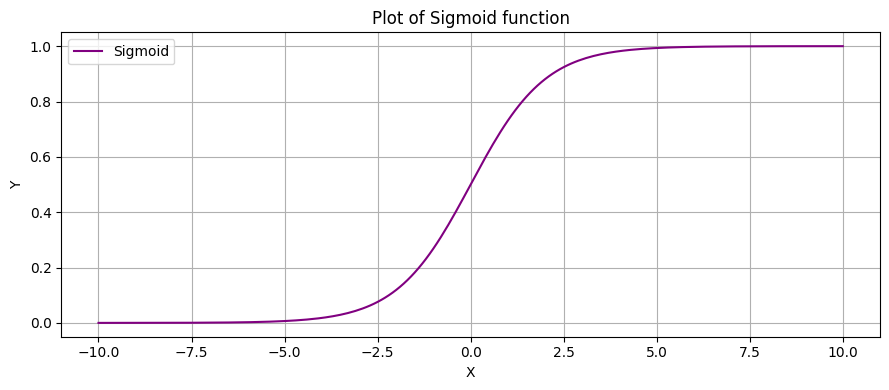

In [30]:
def sigmoid(x):
    return 1 / (1 + mx.np.exp(-x))

X = mx.np.arange(-10, 10.1, 0.1)
Y = sigmoid(X)

# Plot
plt.figure(figsize=(9, 4))
plt.plot(X.asnumpy(), Y.asnumpy(), label='Sigmoid', color='purple')
plt.title('Plot of Sigmoid function')
plt.xlabel('X')
plt.ylabel('Y')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

Now that we have the pieces, let's see how they are used.

### Forward-Propagation

Forward-propagating an input is straightforward. We work through each layer of our network calculating the outputs for each neuron. All of the outputs from one layer become inputs to the neurons on the next layer. Below is a function named `forward_propagate()` that implements the forward-propagation for a row of data from our dataset with our neural network.

You can see that a neuron’s output value is stored in the neuron with the name `output`. You can also see that we collect the outputs for a layer in an array named `new_inputs` that becomes the array inputs and is used as inputs for the following layer. The function returns the outputs from the last layer also called the output layer.

Let’s put all of these pieces together and test out the forward-propagation of our network. We define our network inline with one hidden neuron that expects 2 input values and an output layer with two neurons.


In [31]:
def forward_propagate_tensor(network_weights, row):
    inputs = mx.nd.array(row)

    for weights in network_weights:
        inputs = mx.nd.concat(inputs, mx.nd.ones((1,)), dim=0)

        activations = mx.nd.dot(weights, inputs)

        inputs = SML.transfer(activations)

    return inputs
sml.add_to_class(sml, 'forward_propagate_tensor', forward_propagate_tensor)

In [32]:
network_weights = [
    mx.nd.array([[0.13436424, 0.84743373, 0.76377462]]),
    mx.nd.array([
        [0.25506903, 0.49543509],
        [0.44949106, 0.65159297]
    ])
]

row = [1.0, 0.0]

output = sml.forward_propagate_tensor(network_weights, row)

print("Tensorized forward output:", output.asnumpy().tolist())

Tensorized forward output: [0.6629970073699951, 0.725316047668457]


Running the example propagates the input pattern [1, 0] and produces an output value that is printed. Because the output layer has two neurons, we get a list of two numbers as output. The actual output values are just nonsense for now, but next, we will start to learn how to make the weights in the neurons more useful.

[0.6629970129852887, 0.7253160725279748]  
Sample Output from Forward-Propagate Input Through a Network.

## 15.2.3 Backpropagate Error

The backpropagation algorithm is named for the way in which weights are trained. Error is calculated between the expected outputs and the outputs forward-propagated from the network. These errors are then propagated backward through the network from the output layer to the hidden layer, assigning blame for the error and updating weights as they go. The math for backpropagating error is rooted in calculus, but we will remain high level in this section and focus on what is calculated and how rather than why the calculations take this particular form.

This part is broken down into two sections:

1. Transfer Derivative.  
2. Error Backpropagation.

### Transfer Derivative

Given an output value from a neuron, we need to calculate its slope. We are using the sigmoid transfer function, the derivative of which can be calculated as follows:

$$
\text{derivative} = \text{output} \times (1.0 - \text{output})
\tag{15.3}
$$

Below is a function named `transfer_derivative()` that implements this equation.


In [33]:
def transfer_derivative(output):
    return output * (1.0 - output)
sml.add_to_class(sml, 'transfer_derivative', transfer_derivative)

Now, let’s see how this can be used.

### Error Backpropagation

The first step is to calculate the error for each output neuron; this will give us our error signal (input) to propagate backwards through the network. The error for a given neuron can be calculated as follows:

$$
\text{error} = (\text{expected} - \text{output}) \times \text{transfer\_derivative(output)} \tag{15.4}
$$

Where expected is the expected output value for the neuron, output is the output value for the neuron and transfer_derivative() calculates the slope of the neurons output value, as shown above. This error calculation is used for neurons in the output layer. The expected value is the class value itself. In the hidden layer, things are a little more complicated.

The error signal for a neuron in the hidden layer is calculated as the weighted error of each neuron in the output layer. Think of the error traveling back along the weights of the output layer to the neurons in the hidden layer. The backpropagated error signal is accumulated and then used to determine the error for the neuron in the hidden layer, as follows:

$$
\text{error} = \left(\sum_j \text{weight}_{j} \times \text{error}_{j}\right) \times \text{transfer\_derivative(output)} \tag{15.5}
$$

Where error_j is the error signal from the jth neuron in the output layer, weight_j is the weight that connects the kth neuron to the current neuron and output is the output for the current neuron. Below is a function named `backward_propagate_error()` that implements this procedure. You can see that the error signal calculated for each neuron is stored with the name `delta`.

You can see that the layers of the network are iterated in reverse order, starting at the output and working backwards. This ensures that the neurons in the output layer have delta values calculated first that neurons in the hidden layer can use in the subsequent iteration. I chose the name delta to reflect the change the error implies on the neuron (e.g. the weight delta).

You can see that the error signal for neurons in the hidden layer is accumulated from neurons in the output layer where the hidden neuron number j is also the index of the neurons weight in the output layer neuron[weights][j].


In [ ]:
def backward_propagate_error_tensor(network_weights, activations, expected):
    deltas = [None] * len(network_weights)

    output = activations[-1]
    error = expected - output
    delta = error * sml.transfer_derivative(output)
    deltas[-1] = delta

    for i in reversed(range(len(network_weights) - 1)):
        next_weights = network_weights[i + 1][:, :-1]
        next_delta = deltas[i + 1]

        error = mx.nd.dot(next_weights.T, next_delta)
        delta = error * sml.transfer_derivative(activations[i + 1])
        deltas[i] = delta

    return deltas
sml.add_to_class(sml, 'backward_propagate_error_tensor', backward_propagate_error_tensor)

In [ ]:
network_weights = [
    mx.nd.array([[0.13436424, 0.84743374, 0.76377462]]),
    mx.nd.array([
        [0.25506903, 0.49543509],
        [0.44949106, 0.65159297]
    ])
]

activations = [
    mx.nd.array([1.0, 0.0]),
    mx.nd.array([0.71056688]),
    mx.nd.array([0.62133597, 0.65736935])
]

expected = mx.nd.array([0.0, 1.0])

deltas = sml.backward_propagate_error_tensor(network_weights, activations, expected)

for i, delta in enumerate(deltas):
    print(f"Layer {i} delta:", delta.asnumpy().tolist())

Layer 0 delta: [-0.0005345838144421577]
Layer 1 delta: [-0.14618642628192902, 0.07717236876487732]


Running the example prints the network after the backpropagation of error is complete. You can see that error values are calculated and stored in the neurons for the output layer and the hidden layer.

```json
[{'output': 0.7105668883115941,
  'weights': [0.13436424411240122, 0.8474337369372327, 0.763774618976614]},
 {'delta': -0.0005348048046610517}]

[{'output': 0.6218359615555266,
  'weights': [0.2550690257394217, 0.49543508709194095],
  'delta': -0.14619064683582808},
 {'output': 0.6573693455986976,
  'weights': [0.4494910647887381, 0.651592972722763],
  'delta': 0.0771723774346327}]
```

Sample Output from Backpropagate Error Through a Network.


## 15.2.4 Train Network

The network is trained using stochastic gradient descent. Gradient descent was introduced and described in Section 8.1.2. The procedure involves multiple iterations of exposing a training dataset to the network and for each row of data forward-propagating the inputs, backpropagating the error and updating the network weights. This part is broken down into two sections:

1. Update Weights  
2. Train Network

### Update Weights

Once errors are calculated for each neuron in the network via the backpropagation method above, they can be used to update weights. Network weights are updated as follows:

$$
\text{weight} = \text{weight} + \text{learning rate} \times \text{error} \times \text{input}
\tag{15.6}
$$

Where `weight` is a given weight, `learning rate` is a parameter that you must specify, `error` is the error calculated by the backpropagation procedure for the neuron and `input` is the input value that caused the error. The same procedure can be used for updating the bias weight, except there is no input term, or input is the fixed value of 1.0.

Learning rate controls how much to change the weight to correct for the error. For example, a value of 0.1 will update the weight 10% of the amount that it possibly could be updated. Small learning rates are preferred that cause slower learning over a large number of training iterations. This increases the likelihood of the network finding a good set of weights across all layers rather than the fastest set of weights that minimize error (called premature convergence).

Below is a function named `update_weights()` that updates the weights for a network given an input row of data, a learning rate and assume that a forward and backward propagation have already been performed. Remember that the input for the output layer is a collection of outputs from the hidden layer.

In [ ]:
def update_weights_tensor(network, row, learning_rate):
    inputs = mx.nd.array(row[:-1])

    for i, layer in enumerate(network):
        if i != 0:
            inputs = mx.nd.array([neuron['output'] for neuron in network[i - 1]])

        for neuron in layer:
            weights = neuron['weights']
            delta = neuron['delta']
            
            weight_update = learning_rate * delta * inputs
            weights[:-1] = weights[:-1] + weight_update

            weights[-1] = weights[-1] + learning_rate * delta

            neuron['weights'] = weights

sml.add_to_class(sml, 'update_weights_tensor', update_weights_tensor)

In [49]:
def train_network(network, train_data, learning_rate, n_epochs, n_outputs, test_data=None):
    train_losses = []
    test_losses = []

    for epoch in range(1, n_epochs + 1):
        sum_error = 0.0

        for row in train_data:
            activations = sml.forward_propagate_tensor(network, mx.nd.array(row[:-1]))
            outputs = activations[-1]

            expected = mx.nd.zeros(n_outputs)
            expected[int(row[-1])] = 1.0

            sum_error += mx.nd.sum(mx.nd.square(expected - outputs)).asscalar()

            deltas = sml.backward_propagate_error_tensor(
                [neuron['weights'] for layer in network for neuron in layer],
                activations,
                expected
            )
            sml.update_weights_tensor(network, row, learning_rate)

        if epoch % 10 == 0 or epoch == 1:
            print(f"Epoch={epoch}, lrate={learning_rate:.3f}, error={sum_error:.3f}")

        train_losses.append(sum_error)

        if test_data:
            sum_error = 0.0
            for row in test_data:
                activations = SML.forward_propagate_tensor(network, mx.nd.array(row[:-1]))
                outputs = activations[-1]
                expected = mx.nd.zeros(n_outputs)
                expected[int(row[-1])] = 1.0
                sum_error += mx.nd.sum(mx.nd.square(expected - outputs)).asscalar()
            test_losses.append(sum_error)

    return network, train_losses, test_losses
sml.add_to_class(sml, 'train_network', train_network)

In [56]:
dataset = [
    [2.7810836, 2.550537003, 0],
    [1.465489372, 2.362125076, 0],
    [3.396561688, 4.400293529, 0],
    [1.38807019, 1.850220317, 0],
    [3.06407232, 3.005305973, 0],
    [7.627531214, 2.759262235, 1],
    [5.332441248, 2.088626775, 1],
    [6.922596716, 1.77106367, 1],
    [8.675418651, -0.242068655, 1],
    [7.673756466, 3.508563011, 1]
]

print(f"{'X1':<15} {'X2':<15} {'Y'}")

for row in dataset:
    print(f"{row[0]:<15.9f} {row[1]:<15.9f} {int(row[2])}")


X1              X2              Y
2.781083600     2.550537003     0
1.465489372     2.362125076     0
3.396561688     4.400293529     0
1.388070190     1.850220317     0
3.064072320     3.005305973     0
7.627531214     2.759262235     1
5.332441248     2.088626775     1
6.922596716     1.771063670     1
8.675418651     -0.242068655    1
7.673756466     3.508563011     1


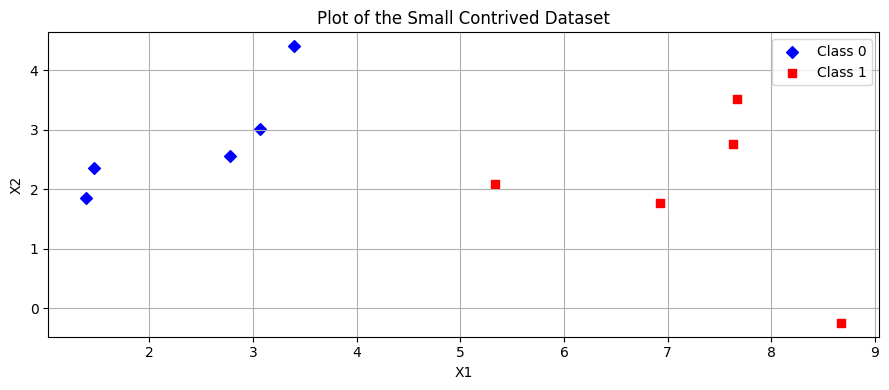

In [57]:
class0 = [row for row in dataset if row[2] == 0]
class1 = [row for row in dataset if row[2] == 1]

x0 = [row[0] for row in class0]
y0 = [row[1] for row in class0]

x1 = [row[0] for row in class1]
y1 = [row[1] for row in class1]

plt.figure(figsize=(9, 4))
plt.scatter(x0, y0, color='blue', marker='D', label='Class 0')
plt.scatter(x1, y1, color='red', marker='s', label='Class 1')

plt.title('Plot of the Small Contrived Dataset')
plt.xlabel('X1')
plt.ylabel('X2')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Below is the complete example. We will use 2 neurons in the hidden layer. It is a binary classification problem (2 classes) so there will be two neurons in the output layer. The network will be trained for 20 epochs with a learning rate of 0.5, which is high because we are training for so few iterations.


In [59]:
n_inputs = len(dataset[0]) - 1
n_outputs = len(set(row[-1] for row in dataset))

network = sml.initialize_network(n_inputs, 2, n_outputs)

network, train_losses, _ = sml.train_network(
    network,
    train_data=dataset,  # <-- así, sin mx.nd.array()
    learning_rate=0.5,
    n_epochs=20,
    n_outputs=n_outputs
)

for i, layer in enumerate(network):
    print(f"Layer {i}:")
    for neuron in layer:
        print({k: v if not isinstance(v, mx.nd.NDArray) else v.asnumpy().tolist()
               for k, v in neuron.items()})

AssertionError: Argument lhs must have NDArray type, but got [{'weights': 
[0.82589036 0.83770555 0.894476  ]
<NDArray 3 @cpu(0)>}, {'weights': 
[0.03315495 0.5011699  0.78476477]
<NDArray 3 @cpu(0)>}]